In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
from datetime import datetime, date
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

import geopandas
import branca.colormap as cm
from branca.element import Template, MacroElement
import folium
from folium import plugins

In [2]:
# mac os
font_path = '/Library/Fonts/simhei.ttf'
fontP = font_manager.FontProperties(fname=font_path)
fontP.set_size(14)


In [3]:
tot_pop_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='total_pop')
pop_province_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='pop_province')
gender_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='gender')
age_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='age')
educ_df = pd.read_excel('census_2020.xlsx', engine='openpyxl', sheet_name='educ')

province_gdf = geopandas.read_file('../geo_datasets/china_province_geo.json', driver='JSON')
china_gdf = geopandas.read_file('../geo_datasets/china_geo.json', driver='JSON')

In [4]:
def autolabel_lineplot(ax, df, col_name, color):
    """
    Attach a text label above each line displaying its height
    """
    for i, val in enumerate(df[col_name]):
        ax.text(df.index[i],
                1.05 * val,
                val,
                color=color,
                rotation=0,
                fontsize=12)



def autolabel_simple_barplot(ax, rects, color):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height().round(2).astype(float)
        ax.text(rect.get_x() + rect.get_width() / 2.,
                0.5 + height,
                '%1.1f' % height,
                fontsize=13,
                ha='center', va='center', color=color)

## 全国人口情况

全国总人口为1443497378人，其中：
- 普查登记的大陆31个省、自治区、直辖市和现役军人的人口共1411778724人；
- 香港特别行政区人口为7474200人；
- 澳门特别行政区人口为683218人；
- 台湾地区人口为23561236人。

/Users/jingwen/github/python-playground/_venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:2020: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jingwen/github/python-playground/_venv/lib/python3.9/site-packages/matplotlib/axes/_base.py:249: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jingwen/github/python-playground/_venv/lib/python3.9/site-packages/matplotlib/axes/_base.py:251: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


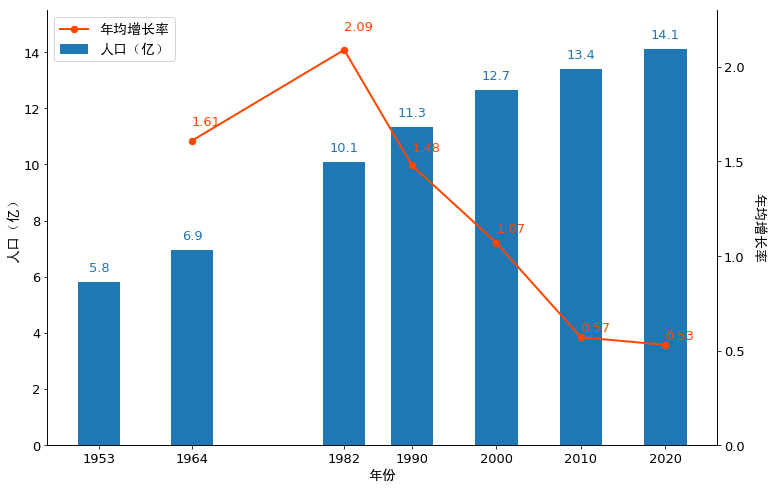

In [5]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
width = 5
rects1 = axarr.bar(tot_pop_df['年份'],
                   tot_pop_df['人口（亿）'],
                   width=width)

axarr.tick_params(labelsize=13)
axarr.set_xlabel('年份', size=13, fontproperties=fontP)
axarr.set_ylabel('人口（亿）', size=13, fontproperties=fontP)
axarr.set_xticks(tot_pop_df['年份'])
axarr.set_xticklabels(tot_pop_df['年份'])
axarr.set_ylim(0, 15.5)
axarr.spines['top'].set_visible(False)
autolabel_simple_barplot(axarr, rects=rects1, color='#1f77b4')

ax_02 = axarr.twinx()
line_rate, = ax_02.plot(tot_pop_df['年份'],
                   tot_pop_df['年均增长率'],
                           color='orangered',
                           linewidth=2,
                           marker='.',
                           markersize=13)
ax_02.tick_params(labelsize=13)
ax_02.set_ylim(0, 2.3)
ax_02.spines['top'].set_visible(False)
ax_02.set_ylabel('年均增长率', size=13, rotation=270, labelpad=20, fontproperties=fontP)

for i, val in enumerate(tot_pop_df['年均增长率'][1:]):
    ax_02.text(tot_pop_df['年份'][i+1],
               1.05 * val,
               val,
               color='orangered',
               rotation=0,
               fontsize=13)

ax_02.legend(handles=(line_rate, rects1),
             fontsize=13,
             labels=('年均增长率', '人口（亿）'), loc=2, prop=fontP)


全国人口与2010年第六次全国人口普查的1339724852人相比，增加72053872人，增长5.38%，年平均增长率为0.53%。

## 地区人口情况

In [6]:
province_pop_geo = pd.merge(pop_province_df,
                            province_gdf[['name', 'geometry']],
                            left_on='地区',
                            right_on='name')

province_pop_geo = province_pop_geo.drop(columns='name')
province_pop_geo = province_pop_geo.dropna()

In [7]:
crs = {'init': 'epsg:4326'}
province_pop_gdf = geopandas.GeoDataFrame(province_pop_geo, crs=crs)

/Users/jingwen/github/python-playground/_venv/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-7-4fb6cacdbce6>:2: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  province_pop_gdf = geopandas.GeoDataFrame(province_pop_geo, crs=crs)


In [8]:
template_province = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body> 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:16px; right: 20px; top: 20px;'>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
<div class='legend-title'>Population proportion</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#fdeed5;opacity:1;'></span>0.0% - 1.4%</li>
    <li><span style='background:#f6a88e;opacity:1;'></span>1.4% - 1.8%</li>
    <li><span style='background:#e86558;opacity:1;'></span>1.8% - 2.8%</li>
    <li><span style='background:#d13035;opacity:1;'></span>2.8% - 3.6%</li>
    <li><span style='background:#8c1f28;opacity:1;'></span>3.6% - 5.2%</li>
    <li><span style='background:#59060a;opacity:1;'></span>> 5.2%</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [9]:
template_province_title = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:0px; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:25px; left: 60px; top: 0px;'>
<div class='legend-title'>Population distribution</div>
<div class='legend-scale'><font size="3">Mainland China / 31 provinces, autonomous regions & municipalities / November 1, 2020 </font></div>
</div>

</body>
</html>

{% endmacro %}"""


In [ ]:
province_pop_gdf.describe(percentiles=(0.16, 0.32, 0.67, 0.83))

In [10]:
province_map = folium.Map(location=[36.130926, 106.925774],
                          zoom_start=4, tiles='cartodbpositron')

colormap_province = cm.StepColormap(
    colors=['#fdeed5', '#f6a88e', '#e86558',
            '#d13035', '#8c1f28', '#59060a'],
    vmin=min(province_pop_gdf['比重（2020）']),
    vmax=max(province_pop_gdf['比重（2020）']),
    index=[1.4, 1.8, 2.8, 3.6, 5.2, 10])

style_function = lambda x: {
    'fillColor': colormap_province(x['properties']['比重（2020）']),
    'color': '',
    'weight': 0.0001,
    'fillOpacity': 1
}

folium.GeoJson(
    province_pop_gdf[province_pop_gdf['比重（2020）']>0][['地区', '比重（2020）', 'geometry']],
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
            fields=['地区', '比重（2020）'],
            aliases=['地区', '比重（2020）'],
            localize=False
        ),
    name='confirmed').add_to(province_map)

folium.GeoJson(
    province_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
    },
    name='Province').add_to(province_map)

folium.GeoJson(
    china_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 2.5,
        'fillOpacity': 0
    },
    name='China').add_to(province_map)

macro = MacroElement()
macro._template = Template(template_province)
macro2 = MacroElement()
macro2._template = Template(template_province_title)
province_map.get_root().add_child(macro)
province_map.get_root().add_child(macro2)

In [ ]:
province_map.save('province_population_map.html')

31个省份中，人口超过1亿人的省份有2个，在5000万人至1亿人之间的省份有9个，在1000万人至5000万人之间的省份有17个，少于1000万人的省份有3个。其中，人口居前五位的省份合计人口占全国人口比重为35.09%。

分区域看，东部地区人口为563717119人，占39.93%；中部地区人口为364694362人，占25.83%；西部地区人口为382852295人，占27.12%；东北地区人口为98514948人，占6.98%。

与2010年第六次全国人口普查相比，31个省份中，有25个省份人口增加。人口增长较多的5个省份依次为：广东、浙江、江苏、山东、河南，分别增加21709378人、10140697人、6088113人、5734388人、5341952人。

分区域看，与2010年第六次全国人口普查相比，东部地区人口所占比重上升2.15个百分点，中部地区人口所占比重下降0.79个百分点，西部地区人口所占比重上升0.22个百分点，东北地区人口所占比重下降1.20个百分点。

东部地区是指北京、天津、河北、上海、江苏、浙江、福建、山东、广东和海南10省（市）；中部地区是指山西、安徽、江西、河南、湖北和湖南6省；西部地区是指内蒙古、广西、重庆、四川、贵州、云南、西藏、陕西、甘肃、青海、宁夏和新疆12省（区、市）；东北地区是指辽宁、吉林和黑龙江3省。

## 人口性别构成情况

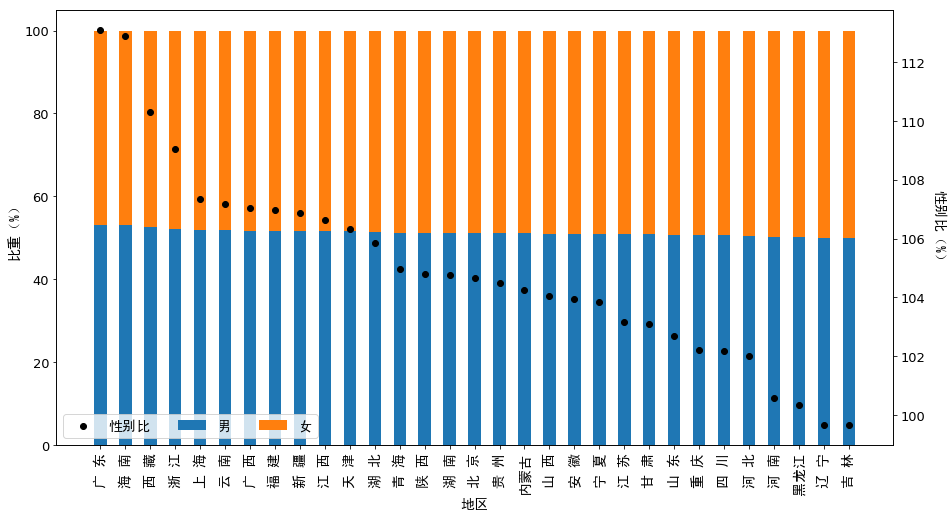

In [11]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
width = 0.5
rect1 = axarr.bar(gender_df.index,
                  gender_df['比重-男'],
                  width=width)
rect2 = axarr.bar(gender_df.index,
                  gender_df['比重-女'],
                  bottom=gender_df['比重-男'],
                  width=width)

axarr.tick_params(labelsize=13)
axarr.set_xlabel('地区', size=13, fontproperties=fontP)
axarr.set_ylabel('比重（%）', size=13, fontproperties=fontP)
axarr.set_xticks(gender_df.index)
axarr.set_xticklabels(gender_df['地区'], rotation=90, fontproperties=fontP)

ax_02 = axarr.twinx()
scatter = ax_02.scatter(gender_df.index, gender_df['性别比'],
                        color='black')

ax_02.tick_params(labelsize=13)
ax_02.set_ylabel('性别比（%）', size=13, rotation=270, labelpad=20, fontproperties=fontP)
ax_02.legend(handles=(scatter, rect1, rect2),
             fontsize=13,
             labels=('性别比', '男', '女'),
             ncol=3, loc=3, prop=fontP)


全国人口中，男性人口为723339956人，占51.24%；女性人口为688438768人，占48.76%。总人口性别比（以女性为100，男性对女性的比例）为105.07，与2010年第六次全国人口普查基本持平。

31个省份中，总人口性别比在100以下的省份有2个，在100至105之间的省份有17个，在105至110之间的省份有9个，在110以上的省份有3个。


## 人口年龄构成情况

In [12]:
age_df = age_df[1:].sort_values('比重60岁及以上', ascending=False).reset_index(drop=True)

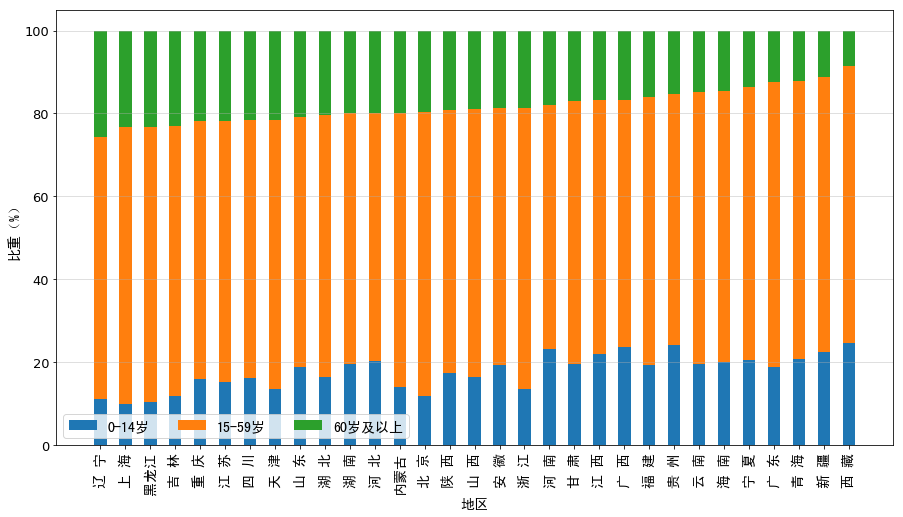

In [13]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
width = 0.5
rect1 = axarr.bar(age_df.index,
                  age_df['比重0-14岁'],
                  width=width)
rect2 = axarr.bar(age_df.index,
                  age_df['比重15-59岁'],
                  bottom=age_df['比重0-14岁'],
                  width=width)
rect3 = axarr.bar(age_df.index,
                  age_df['比重60岁及以上'],
                  bottom=age_df['比重0-14岁']+age_df['比重15-59岁'],
                  width=width)

axarr.tick_params(labelsize=13)
axarr.set_xlabel('地区', size=13, fontproperties=fontP)
axarr.set_ylabel('比重（%）', size=13, fontproperties=fontP)
axarr.set_xticks(age_df.index)
axarr.set_xticklabels(age_df['地区'], rotation=90, fontproperties=fontP)
axarr.grid(which='major', axis='y', alpha=0.5)

axarr.legend(handles=(rect1, rect2, rect3),
             fontsize=13,
             labels=('0-14岁', '15-59岁', '60岁及以上'),
             ncol=3, loc=3, prop=fontP)



全国人口中，0—14岁人口为253383938人，占17.95%；15—59岁人口为894376020人，占63.35%；60岁及以上人口为264018766人，占18.70%，其中65岁及以上人口为190635280人，占13.50%。与2010年第六次全国人口普查相比，0—14岁人口的比重上升1.35个百分点，15—59岁人口的比重下降6.79个百分点，60岁及以上人口的比重上升5.44个百分点，65岁及以上人口的比重上升4.63个百分点。

31个省份中，15—59岁人口比重在65%以上的省份有13个，在60%—65%之间的省份有15个，在60%以下的省份有3个。
除西藏外，其他30个省份65岁及以上老年人口比重均超过7%，其中，12个省份65岁及以上老年人口比重超过14%。

## 人口受教育情况